# Nonparametric ML Models - Cumulative Lab

## Introduction

In this cumulative lab, you will apply two nonparametric models you have just learned — k-nearest neighbors and decision trees — to the forest cover dataset.

## Objectives

* Practice identifying and applying appropriate preprocessing steps
* Perform an iterative modeling process, starting from a baseline model
* Explore multiple model algorithms, and tune their hyperparameters
* Practice choosing a final model across multiple model algorithms and evaluating its performance

## Your Task: Complete an End-to-End ML Process with Nonparametric Models on the Forest Cover Dataset

![line of pine trees](images/trees.jpg)

Photo by <a href="https://unsplash.com/@michaelbenz?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Michael Benz</a> on <a href="/s/photos/forest?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

### Business and Data Understanding

To repeat the previous description:

> Here we will be using an adapted version of the forest cover dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/covertype). Each record represents a 30 x 30 meter cell of land within Roosevelt National Forest in northern Colorado, which has been labeled as `Cover_Type` 1 for "Cottonwood/Willow" and `Cover_Type` 0 for "Ponderosa Pine". (The original dataset contained 7 cover types but we have simplified it.)

The task is to predict the `Cover_Type` based on the available cartographic variables:

In [1]:
# Run this cell without changes
import pandas as pd

df = pd.read_csv('data/forest_cover.csv')
df

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,2553,235,17,351,95,780,188,253,199,1410,...,0,0,0,0,0,0,0,0,0,0
1,2011,344,17,313,29,404,183,211,164,300,...,0,0,0,0,0,0,0,0,0,0
2,2022,24,13,391,42,509,212,212,134,421,...,0,0,0,0,0,0,0,0,0,0
3,2038,50,17,408,71,474,226,200,102,283,...,0,0,0,0,0,0,0,0,0,0
4,2018,341,27,351,34,390,152,188,168,190,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38496,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,0
38497,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,0
38498,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,0
38499,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,0


> As you can see, we have over 38,000 rows, each with 52 feature columns and 1 target column:

> * `Elevation`: Elevation in meters
> * `Aspect`: Aspect in degrees azimuth
> * `Slope`: Slope in degrees
> * `Horizontal_Distance_To_Hydrology`: Horizontal dist to nearest surface water features in meters
> * `Vertical_Distance_To_Hydrology`: Vertical dist to nearest surface water features in meters
> * `Horizontal_Distance_To_Roadways`: Horizontal dist to nearest roadway in meters
> * `Hillshade_9am`: Hillshade index at 9am, summer solstice
> * `Hillshade_Noon`: Hillshade index at noon, summer solstice
> * `Hillshade_3pm`: Hillshade index at 3pm, summer solstice
> * `Horizontal_Distance_To_Fire_Points`: Horizontal dist to nearest wildfire ignition points, meters
> * `Wilderness_Area_x`: Wilderness area designation (3 columns)
> * `Soil_Type_x`: Soil Type designation (39 columns)
> * `Cover_Type`: 1 for cottonwood/willow, 0 for ponderosa pine

This is also an imbalanced dataset, since cottonwood/willow trees are relatively rare in this forest:

In [2]:
# Run this cell without changes
print("Raw Counts")
print(df["Cover_Type"].value_counts())
print()
print("Percentages")
print(df["Cover_Type"].value_counts(normalize=True))

Raw Counts
0    35754
1     2747
Name: Cover_Type, dtype: int64

Percentages
0    0.928651
1    0.071349
Name: Cover_Type, dtype: float64


Thus, a baseline model that always chose the majority class would have an accuracy of over 92%. Therefore we will want to report additional metrics at the end.

### Previous Best Model

In a previous lab, we used SMOTE to create additional synthetic data, then tuned the hyperparameters of a logistic regression model to get the following final model metrics:

* **Log loss:** 0.13031294393913376
* **Accuracy:** 0.9456679825472678
* **Precision:** 0.6659919028340081
* **Recall:** 0.47889374090247455

In this lab, you will try to beat those scores using more-complex, nonparametric models.

### Modeling

Although you may be aware of some additional model algorithms available from scikit-learn, for this lab you will be focusing on two of them: k-nearest neighbors and decision trees. Here are some reminders about these models:

#### kNN - [documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

This algorithm — unlike linear models or tree-based models — does not emphasize learning the relationship between the features and the target. Instead, for a given test record, it finds the most similar records in the training set and returns an average of their target values.

* **Training speed:** Fast. In theory it's just saving the training data for later, although the scikit-learn implementation has some additional logic "under the hood" to make prediction faster.
* **Prediction speed:** Very slow. The model has to look at every record in the training set to find the k closest to the new record.
* **Requires scaling:** Yes. The algorithm to find the nearest records is distance-based, so it matters that distances are all on the same scale.
* **Key hyperparameters:** `n_neighbors` (how many nearest neighbors to find; too few neighbors leads to overfitting, too many leads to underfitting), `p` and `metric` (what kind of distance to use in defining "nearest" neighbors)

#### Decision Trees - [documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

Similar to linear models (and unlike kNN), this algorithm emphasizes learning the relationship between the features and the target. However, unlike a linear model that tries to find linear relationships between each of the features and the target, decision trees look for ways to split the data based on features to decrease the entropy of the target in each split.

* **Training speed:** Slow. The model is considering splits based on as many as all of the available features, and it can split on the same feature multiple times. This requires exponential computational time that increases based on the number of columns as well as the number of rows.
* **Prediction speed:** Medium fast. Producing a prediction with a decision tree means applying several conditional statements, which is slower than something like logistic regression but faster than kNN.
* **Requires scaling:** No. This model is not distance-based. You also can use a `LabelEncoder` rather than `OneHotEncoder` for categorical data, since this algorithm doesn't necessarily assume that the distance between `1` and `2` is the same as the distance between `2` and `3`.
* **Key hyperparameters:** Many features relating to "pruning" the tree. By default they are set so the tree can overfit, and by setting them higher or lower (depending on the hyperparameter) you can reduce overfitting, but too much will lead to underfitting. These are: `max_depth`, `min_samples_split`, `min_samples_leaf`, `min_weight_fraction_leaf`, `max_features`, `max_leaf_nodes`, and `min_impurity_decrease`. You can also try changing the `criterion` to "entropy" or the `splitter` to "random" if you want to change the splitting logic.

### Requirements

#### 1. Prepare the Data for Modeling

#### 2. Build a Baseline kNN Model

#### 3. Build Iterative Models to Find the Best kNN Model

#### 4. Build a Baseline Decision Tree Model

#### 5. Build Iterative Models to Find the Best Decision Tree Model

#### 6. Choose and Evaluate an Overall Best Model

## 1. Prepare the Data for Modeling

The target is `Cover_Type`. In the cell below, split `df` into `X` and `y`, then perform a train-test split with `random_state=42` and `stratify=y` to create variables with the standard `X_train`, `X_test`, `y_train`, `y_test` names.

Include the relevant imports as you go.

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
# Your code here
y = df['Cover_Type']
X = df.drop(columns='Cover_Type')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

Now, instantiate a `StandardScaler`, fit it on `X_train`, and create new variables `X_train_scaled` and `X_test_scaled` containing values transformed with the scaler.

In [5]:
# Your code here
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

The following code checks that everything is set up correctly:

In [6]:
# Run this cell without changes

# Checking that df was separated into correct X and y
assert type(X) == pd.DataFrame and X.shape == (38501, 52)
assert type(y) == pd.Series and y.shape == (38501,)

# Checking the train-test split
assert type(X_train) == pd.DataFrame and X_train.shape == (28875, 52)
assert type(X_test) == pd.DataFrame and X_test.shape == (9626, 52)
assert type(y_train) == pd.Series and y_train.shape == (28875,)
assert type(y_test) == pd.Series and y_test.shape == (9626,)

# Checking the scaling
assert X_train_scaled.shape == X_train.shape
assert round(X_train_scaled[0][0], 3) == -0.636
assert X_test_scaled.shape == X_test.shape
assert round(X_test_scaled[0][0], 3) == -1.370

## 2. Build a Baseline kNN Model

Build a scikit-learn kNN model with default hyperparameters. Then use `cross_val_score` with `scoring="neg_log_loss"` to find the mean log loss for this model (passing in `X_train_scaled` and `y_train` to `cross_val_score`). You'll need to find the mean of the cross-validated scores, and negate the value (either put a `-` at the beginning or multiply by `-1`) so that your answer is a log loss rather than a negative log loss.

Call the resulting score `knn_baseline_log_loss`.

Your code might take a minute or more to run.

In [8]:
# Replace None with appropriate code

# Relevant imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Creating the model
knn_baseline_model = KNeighborsClassifier()

# Perform cross-validation
knn_baseline_log_loss = -cross_val_score(knn_baseline_model, X_train_scaled, y_train, scoring="neg_log_loss").mean()

knn_baseline_log_loss

0.1255288892455634

Our best logistic regression model had a log loss of 0.13031294393913376

Is this model better? Compare it in terms of metrics and speed.

In [ ]:
# Replace None with appropriate text
"""
The value was a little lower for the kNN model compared to the logistic regression model, showing an improvement in the
model.
This did take over a minute to run on my laptop, which was slower than the logistic regression.
"""

## 3. Build Iterative Models to Find the Best kNN Model

Build and evaluate at least two more kNN models to find the best one. Explain why you are changing the hyperparameters you are changing as you go. These models will be *slow* to run, so be thinking about what you might try next as you run them.

First, I am going to loop through several values of k. The k hyperparameter has a major effect on whether the model is underfitting or overfitting.

In [10]:
# Your code here (add more cells as needed)
min_k, max_k = 1, 21
k = min_k

k_results = []

best_k = 1
best_log_loss = 100.0
while k <= max_k:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_log_loss = -cross_val_score(knn_model, X_train_scaled, y_train, scoring="neg_log_loss").mean()
    
    if knn_log_loss < best_log_loss:
        best_k = k
        best_log_loss = knn_log_loss
        
    k_results.append([k, knn_log_loss])
    print(k, knn_log_loss)
    
    k += 2
print(f"Best k: {best_k}")
print(f"Best log loss: {best_log_loss}")

1 0.49521049185151506
3 0.17451432403739855
5 0.1255288892455634
7 0.0895925912090358
9 0.07966757716809988
11 0.07273052026135858
13 0.06972901169429604
15 0.06722997851589525
17 0.06376302967813
19 0.0633161801415997
21 0.06505037780145134
Best k: 19
Best log loss: 0.0633161801415997


In [14]:
import matplotlib.pyplot as plt
import numpy as np

Text(0, 0.5, 'Log Loss')

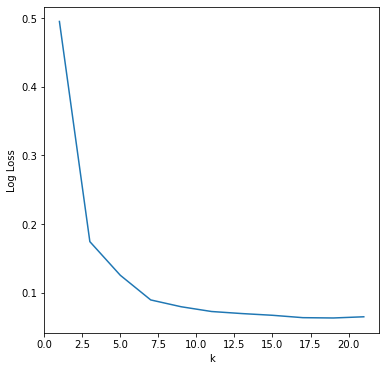

In [15]:
fig, ax = plt.subplots(figsize=(6,6))

k_results = np.array(k_results)

ax.plot(k_results[:,0],k_results[:,1])
ax.set_xlabel('k')
ax.set_ylabel('Log Loss')

Next, I try out different values for the metric exponent. I use the best k value that I found from the previous search.

In [16]:
# Your code here (add more cells as needed)
min_p, max_p = 1, 3.5
delta_p = 0.5
p = min_p

p_results = []

best_p = 1
best_log_loss = 100.0
while p <= max_p:
    knn_model = KNeighborsClassifier(p=p, n_neighbors=best_k)
    knn_log_loss = -cross_val_score(knn_model, X_train_scaled, y_train, scoring="neg_log_loss").mean()
    
    if knn_log_loss < best_log_loss:
        best_p = p
        best_log_loss = knn_log_loss
        
    p_results.append([p, knn_log_loss])
    print(p, knn_log_loss)
    
    p += delta_p
print(f"Best p: {best_p}")
print(f"Best log loss: {best_log_loss}")

1 0.061214951514946325
1.5 0.06337367550589328
2.0 0.0633161801415997
2.5 0.06674078378419114
3.0 0.06873177825082794
3.5 0.07264705843828806
Best p: 1
Best log loss: 0.061214951514946325


Text(0, 0.5, 'Log Loss')

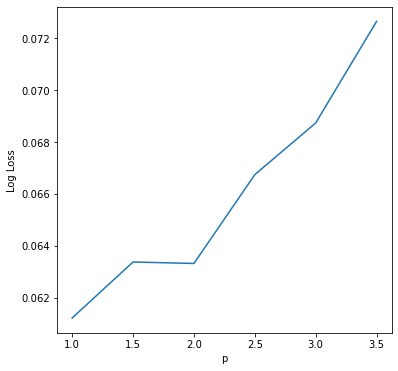

In [17]:
# Your code here (add more cells as needed)
fig, ax = plt.subplots(figsize=(6,6))

p_results = np.array(p_results)

ax.plot(p_results[:,0],p_results[:,1])
ax.set_xlabel('p')
ax.set_ylabel('Log Loss')

The best kNN model had k=19 and p=1.

## 4. Build a Baseline Decision Tree Model

Now that you have chosen your best kNN model, start investigating decision tree models. First, build and evaluate a baseline decision tree model, using default hyperparameters (with the exception of `random_state=42` for reproducibility).

(Use cross-validated log loss, just like with the previous models.)

In [18]:
# Your code here
from sklearn.tree import DecisionTreeClassifier

In [19]:
dtc_baseline_model = DecisionTreeClassifier(random_state=42)
dtc_log_loss = -cross_val_score(dtc_baseline_model, X_train_scaled, y_train, scoring="neg_log_loss").mean()
dtc_log_loss

0.7057351605151588

Interpret this score. How does this compare to the log loss from our best logistic regression and best kNN models? Any guesses about why?

In [ ]:
# Replace None with appropriate text
"""
This number is quite a bit higher than the kNN models tried out before. This might be because the default values for the
decision tree model are not as good as the default parameters for the kNN model.
"""

## 5. Build Iterative Models to Find the Best Decision Tree Model

Build and evaluate at least two more decision tree models to find the best one. Explain why you are changing the hyperparameters you are changing as you go.

The hyperparameters we have adjusted in other notebooks were max_depth, min_sample_split, and min_sample_leaf. These are the main ones I am going to try.
I am going to try a grid search.

In [23]:
# Your code here (add more cells as needed)
max_depth = [None,4,8,12]
min_samples_split = [2,4,8,16]
min_samples_leaf = [1,2,4,8]

best_combo = [0,0,0]
best_log_loss = 100.0

n_combos = len(max_depth)*len(min_samples_split)*len(min_samples_leaf)
n = 0
while n < n_combos:
    i = n // (len(min_samples_split)*len(min_samples_leaf))
    j = (n // len(min_samples_leaf)) % len(min_samples_split)
    k = n % len(min_samples_leaf)
    
    dtc_model = DecisionTreeClassifier(
        random_state=42, 
        max_depth=max_depth[i], 
        min_samples_split=min_samples_split[j], 
        min_samples_leaf=min_samples_leaf[k])
    
    dtc_log_loss = -cross_val_score(dtc_model, X_train_scaled, y_train, scoring="neg_log_loss").mean()
    
    if dtc_log_loss < best_log_loss:
        best_combo = [i,j,k]
        best_log_loss = dtc_log_loss
        
    print(max_depth[i], min_samples_split[j], min_samples_leaf[k], dtc_log_loss)
    n += 1

print(f"Best Combination:")
print(f"Max Depth: {max_depth[best_combo[0]]}")
print(f"Min Samples Split: {min_samples_split[best_combo[1]]}")
print(f"Min Samples Leaf: {min_samples_leaf[best_combo[2]]}")
print(f"Best Log Loss: {best_log_loss}")

None 2 1 0.7057351605151588
None 2 2 0.5527438012077219
None 2 4 0.43413184052564013
None 2 8 0.3057997757879233
None 4 1 0.6514133350192396
None 4 2 0.5527438012077219
None 4 4 0.43413184052564013
None 4 8 0.3057997757879233
None 8 1 0.5396364169653544
None 8 2 0.47055065845242144
None 8 4 0.43413184052564013
None 8 8 0.3057997757879233
None 16 1 0.44077609491819414
None 16 2 0.37649431868127775
None 16 4 0.3417235468080988
None 16 8 0.3057997757879233
4 2 1 0.13012531033354707
4 2 2 0.13012531033354707
4 2 4 0.13012531033354707
4 2 8 0.13012531033354707
4 4 1 0.13012531033354707
4 4 2 0.13012531033354707
4 4 4 0.13012531033354707
4 4 8 0.13012531033354707
4 8 1 0.13012531033354707
4 8 2 0.13012531033354707
4 8 4 0.13012531033354707
4 8 8 0.13012531033354707
4 16 1 0.13012531033354707
4 16 2 0.13012531033354707
4 16 4 0.13012531033354707
4 16 8 0.13012531033354707
8 2 1 0.1843390271598817
8 2 2 0.1737448977581874
8 2 4 0.1569797878827517
8 2 8 0.12673617103183737
8 4 1 0.1762547097603

The first grid search showed that the best log loss came from a max depth of 8, and minimum samples per leaf of 8. The value of min samples to split did not affect the log loss for these cases.
Now I am going to do a finer grid search around these values.

In [25]:
# Your code here (add more cells as needed)
max_depth = [5,6,7,8,9,10]
min_samples_split = [2,4,8,16]
min_samples_leaf = [5,6,7,8,9,10]

best_combo = [0,0,0]
best_log_loss = 100.0

n_combos = len(max_depth)*len(min_samples_split)*len(min_samples_leaf)
n = 0
while n < n_combos:
    i = n // (len(min_samples_split)*len(min_samples_leaf))
    j = (n // len(min_samples_leaf)) % len(min_samples_split)
    k = n % len(min_samples_leaf)
    
    dtc_model = DecisionTreeClassifier(
        random_state=42, 
        max_depth=max_depth[i], 
        min_samples_split=min_samples_split[j], 
        min_samples_leaf=min_samples_leaf[k])
    
    dtc_log_loss = -cross_val_score(dtc_model, X_train_scaled, y_train, scoring="neg_log_loss").mean()
    
    if dtc_log_loss < best_log_loss:
        best_combo = [i,j,k]
        best_log_loss = dtc_log_loss
        
    print(max_depth[i], min_samples_split[j], min_samples_leaf[k], dtc_log_loss)
    n += 1

print(f"Best Combination:")
print(f"Max Depth: {max_depth[best_combo[0]]}")
print(f"Min Samples Split: {min_samples_split[best_combo[1]]}")
print(f"Min Samples Leaf: {min_samples_leaf[best_combo[2]]}")
print(f"Best Log Loss: {best_log_loss}")

5 2 5 0.11697046090153682
5 2 6 0.116863716227443
5 2 7 0.1181739737562161
5 2 8 0.11706986053338549
5 2 9 0.11594227169091131
5 2 10 0.11606906959187682
5 4 5 0.11697046090153682
5 4 6 0.116863716227443
5 4 7 0.1181739737562161
5 4 8 0.11706986053338549
5 4 9 0.11594227169091131
5 4 10 0.11606906959187682
5 8 5 0.11697046090153682
5 8 6 0.116863716227443
5 8 7 0.1181739737562161
5 8 8 0.11706986053338549
5 8 9 0.11594227169091131
5 8 10 0.11606906959187682
5 16 5 0.11697046090153682
5 16 6 0.116863716227443
5 16 7 0.1181739737562161
5 16 8 0.11706986053338549
5 16 9 0.11594227169091131
5 16 10 0.11606906959187682
6 2 5 0.11152771662265112
6 2 6 0.11218849944037271
6 2 7 0.11239484485977813
6 2 8 0.108695596697212
6 2 9 0.11426080306324297
6 2 10 0.11112035610833775
6 4 5 0.11152771662265112
6 4 6 0.11218849944037271
6 4 7 0.11239484485977813
6 4 8 0.108695596697212
6 4 9 0.11426080306324297
6 4 10 0.11112035610833775
6 8 5 0.11152771662265112
6 8 6 0.11218849944037271
6 8 7 0.11239484

In [ ]:
The second grid search found that a max_depth of 6 is even better than a max_depth of 8.
The best min_samples_leaf is still 8.
The value of min_samples_split did not affect the result. It is fine to just use the default value.

The best log loss was still achieved by the kNN model.

## 6. Choose and Evaluate an Overall Best Model

Which model had the best performance? What type of model was it?

Instantiate a variable `final_model` using your best model with the best hyperparameters.

In [28]:
# Replace None with appropriate code
final_model = KNeighborsClassifier(p=1, n_neighbors=19)

# Fit the model on the full training data
# (scaled or unscaled depending on the model)
final_model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=19, p=1)

Now, evaluate the log loss, accuracy, precision, and recall. This code is mostly filled in for you, but you need to replace `None` with either `X_test` or `X_test_scaled` depending on the model you chose.

In [30]:
# Replace None with appropriate code
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score

preds = final_model.predict(X_test_scaled)
probs = final_model.predict_proba(X_test_scaled)

print("log loss: ", log_loss(y_test, probs))
print("accuracy: ", accuracy_score(y_test, preds))
print("precision:", precision_score(y_test, preds))
print("recall:   ", recall_score(y_test, preds))

log loss:  0.06448869420648831
accuracy:  0.9779763141491793
precision: 0.9018612521150592
recall:    0.7758369723435226


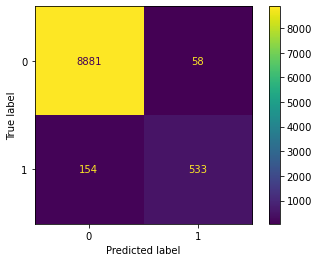

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cf = confusion_matrix(y_test, preds)

disp = ConfusionMatrixDisplay(cf)
disp.plot()

Interpret your model performance. How would it perform on different kinds of tasks? How much better is it than a "dummy" model that always chooses the majority class, or the logistic regression described at the start of the lab?

In [ ]:
# Replace None with appropriate text
"""
The log loss was quite similar to what the cross validation tests achieved, which is a good sign. It indicates we were not
overfitting or underfitting.

The dummy model that always predicts the majority class would have 92.9% accuracy. This model is better at 97.8% accuracy.
It is also better than the logistic regression model that had an accuracy of 94.6%.

The precision is 90.2%, which means that about 90% of the positive predictions actually turn out to be positive. This is much
better than the logistic regression model that only had 67% precision.

The recall is 77.6%, which means that the model is able to correctly classify about 78% of the actual positive cases.
This is also a big improvement over the logistic regression model which only had 48% recall.

This model does a better job of avoiding false positives than false negatives because the precision is higher than the
recall. This means this model is less likely to call a ponderosa pine a cottonwood/willow than it is to do the opposite.
This is good if calling a pine a cottonwood/willow is bad, but if it is more important to identify all the cottonwood/willow
cases (even if it means incorrectly classifying some pines), then this model does not do as well as we might like.
"""

## Conclusion

In this lab, you practiced the end-to-end machine learning process with multiple model algorithms, including tuning the hyperparameters for those different algorithms. You saw how nonparametric models can be more flexible than linear models, potentially leading to overfitting but also potentially reducing underfitting by being able to learn non-linear relationships between variables. You also likely saw how there can be a tradeoff between speed and performance, with good metrics correlating with slow speeds.